In [112]:
import pandas as pd
import numpy as np
# import utils
import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare, ttest_ind
import matplotlib.pyplot as plt
import networkx

In [113]:
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.tight_layout()
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=12)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=18)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=12)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=18)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False, cd_diagram_name="cd-diagram"):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    #print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=3, textspace=0.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig(f'{cd_diagram_name}.pdf',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    # print(pd.unique(df_perf['solver']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['solver']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['solver'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['solver'] == c]['cost'])
        for c in classifiers))[1]
    print(friedman_p_value)
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['solver'] == classifier_1]['cost']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['solver'] == classifier_2]
                              ['cost'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2,zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['solver'].isin(classifiers)]. \
        sort_values(['solver', 'instance'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['cost']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['instance']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    # print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

In [114]:
pd.read_csv(f"../processed-datasets/damodaran/damodaran-our-sa-time-wise.csv", index_col=0)#[["instance_name","our_sa_mean"]].rename(columns={"our_sa_mean":"cost"})

,instance_name,our_sa_min,Jobs,our_sa_mean,size
240,200J_10p_3m_10%_20s-1.dzn,210,200,213.8,large
241,200J_10p_3m_10%_20s-2.dzn,216,200,217.4,large
242,200J_10p_3m_10%_20s-3.dzn,225,200,226.1,large
243,200J_10p_3m_10%_20s-4.dzn,206,200,208.2,large
244,200J_10p_3m_10%_20s-5.dzn,239,200,239.8,large
...,...,...,...,...,...
595,50J_30p_5m_50%_5s-1.dzn,410,50,410.0,medium
596,50J_30p_5m_50%_5s-2.dzn,355,50,355.0,medium
597,50J_30p_5m_50%_5s-3.dzn,385,50,385.0,medium
598,50J_30p_5m_50%_5s-4.dzn,404,50,404.0,medium


large========================
8.535952530373415e-21
('SA-i', 'SA-t', 5.685125670325322e-18, True)
('DA', 'SA-t', 4.234714230206714e-12, True)
('DA', 'SA-i', 1.1555561895459557e-05, True)
Index(['DA', 'SA-i', 'SA-t'], dtype='object')


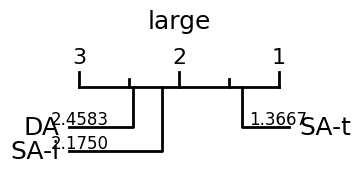

In [115]:
for size in ["large"]:
    print(f"{size}========================")
    # ddf = pd.DataFrame()
    sa_time = pd.read_csv(f"../processed-datasets/damodaran/damodaran-our-sa-time-wise.csv", index_col=0)[["instance_name","our_sa_mean","size"]].rename(columns={"our_sa_mean":"cost"})
    # ddf = pd.concat([ddf,sa_time[["instance_name","cost"]].rename(columns={"cost":"SA_t"})])
    sa_time["solver"] = "SA-t"

    sa_iteration = pd.read_csv(f"../processed-datasets/damodaran/damodaran-our-sa.csv", index_col=0)[["instance_name","our_sa_mean","size"]].rename(columns={"our_sa_mean":"cost"})
    # ddf = pd.concat([ddf,sa_iteration[["instance_name","cost"]].rename(columns={"cost":"SA_i"})])
    sa_iteration["solver"] = "SA-i"
    sa_iteration["cost"] = sa_iteration["cost"] + 0.00000000000000000000001

    sa_original = pd.read_csv(f"../processed-datasets/damodaran/damodaran-original.csv", index_col=0)[["instance_name","damodaran_mean",]].rename(columns={"damodaran_mean":"cost"})
    sizes = sa_iteration[["instance_name","size"]].copy()
    sa_original = pd.merge(sa_original,sizes)
    sa_original["solver"] = "DA"
    
    # ddf["size"] = ddf.apply(lambda row: utils.instance_size(row["instance"]), axis=1)
    # ddf = ddf.query(f"size == '{size}'")
    # ddf[["SA","ILP","CP","LNS"]].to_csv(f"statistical-uc{uc}-{size}.csv")

    df = pd.concat([sa_time,sa_iteration,sa_original]).rename(columns={"instance_name":"instance"})
    # df["size"] = df.apply(lambda row: utils.instance_size(row["instance"]), axis=1)
    df = df.query(f"size == '{size}'").copy().drop(columns=["size"])
    df["cost"] = -1 * df["cost"]
    draw_cd_diagram(df_perf=df, title=f"{size}", labels=True,cd_diagram_name=f"statistical-{size}")

In [116]:
sa_time = pd.read_csv(f"../processed-datasets/damodaran/damodaran-our-sa-time-wise.csv", index_col=0)[["instance_name","our_sa_mean","size"]].rename(columns={"our_sa_mean":"cost"})
# ddf = pd.concat([ddf,sa_time[["instance_name","cost"]].rename(columns={"cost":"SA_t"})])
sa_time["solver"] = "SA-t"

sa_iteration = pd.read_csv(f"../processed-datasets/damodaran/damodaran-our-sa.csv", index_col=0)[["instance_name","our_sa_mean","size"]].rename(columns={"our_sa_mean":"cost"})
# ddf = pd.concat([ddf,sa_iteration[["instance_name","cost"]].rename(columns={"cost":"SA_i"})])
sa_iteration["solver"] = "SA-i"

sa_original = pd.read_csv(f"../processed-datasets/damodaran/damodaran-original.csv", index_col=0)[["instance_name","damodaran_mean",]].rename(columns={"damodaran_mean":"cost"})
sizes = sa_iteration[["instance_name","size"]].copy()
sa_original = pd.merge(sa_original,sizes)
sa_original["solver"] = "DA"

In [117]:
sa_time

,instance_name,cost,size,solver
240,200J_10p_3m_10%_20s-1.dzn,213.8,large,SA-t
241,200J_10p_3m_10%_20s-2.dzn,217.4,large,SA-t
242,200J_10p_3m_10%_20s-3.dzn,226.1,large,SA-t
243,200J_10p_3m_10%_20s-4.dzn,208.2,large,SA-t
244,200J_10p_3m_10%_20s-5.dzn,239.8,large,SA-t
...,...,...,...,...
595,50J_30p_5m_50%_5s-1.dzn,410.0,medium,SA-t
596,50J_30p_5m_50%_5s-2.dzn,355.0,medium,SA-t
597,50J_30p_5m_50%_5s-3.dzn,385.0,medium,SA-t
598,50J_30p_5m_50%_5s-4.dzn,404.0,medium,SA-t


In [118]:
sa_time

,instance_name,cost,size,solver
240,200J_10p_3m_10%_20s-1.dzn,213.8,large,SA-t
241,200J_10p_3m_10%_20s-2.dzn,217.4,large,SA-t
242,200J_10p_3m_10%_20s-3.dzn,226.1,large,SA-t
243,200J_10p_3m_10%_20s-4.dzn,208.2,large,SA-t
244,200J_10p_3m_10%_20s-5.dzn,239.8,large,SA-t
...,...,...,...,...
595,50J_30p_5m_50%_5s-1.dzn,410.0,medium,SA-t
596,50J_30p_5m_50%_5s-2.dzn,355.0,medium,SA-t
597,50J_30p_5m_50%_5s-3.dzn,385.0,medium,SA-t
598,50J_30p_5m_50%_5s-4.dzn,404.0,medium,SA-t


In [119]:
t_small = pd.merge(
    sa_time.query("size == 'small'").rename(columns={"cost":"our"}),
    sa_original.query("size == 'small'").rename(columns={"cost":"DA"}),
    on=["instance_name","size"]
)
t_small = pd.merge(
    sa_iteration.query("size == 'small'").rename(columns={"cost":"ourIT"}),
    t_small,
    on=["instance_name","size"]
)
t_small

,instance_name,ourIT,size,solver,our,solver_x,DA,solver_y
0,10J_10p_3m_10%_20s-1.dzn,16.0,small,SA-i,16.0,SA-t,17.166667,DA
1,10J_10p_3m_10%_20s-2.dzn,18.2,small,SA-i,18.2,SA-t,19.666667,DA
2,10J_10p_3m_10%_20s-3.dzn,14.0,small,SA-i,14.0,SA-t,14.000000,DA
3,10J_10p_3m_10%_20s-4.dzn,15.0,small,SA-i,15.0,SA-t,15.666667,DA
4,10J_10p_3m_10%_20s-5.dzn,18.0,small,SA-i,18.0,SA-t,18.500000,DA
...,...,...,...,...,...,...,...,...
235,20J_30p_5m_50%_5s-1.dzn,131.0,small,SA-i,131.0,SA-t,132.166667,DA
236,20J_30p_5m_50%_5s-2.dzn,188.0,small,SA-i,188.0,SA-t,188.666667,DA
237,20J_30p_5m_50%_5s-3.dzn,149.0,small,SA-i,149.0,SA-t,151.000000,DA
238,20J_30p_5m_50%_5s-4.dzn,155.0,small,SA-i,155.0,SA-t,157.500000,DA


In [120]:
friedmanchisquare(t_small["our"],t_small["DA"],t_small["ourIT"])

FriedmanchisquareResult(statistic=321.9999999999998, pvalue=1.1983630608510073e-70)

In [121]:
t_medium = pd.merge(
    sa_time.query("size == 'medium'").rename(columns={"cost":"our"}),
    sa_original.query("size == 'medium'").rename(columns={"cost":"DA"}),
    on=["instance_name","size"]
)
t_medium = pd.merge(
    sa_iteration.query("size == 'medium'").rename(columns={"cost":"ourIT"}),
    t_medium,
    on=["instance_name","size"]
)
friedmanchisquare(t_medium["our"],t_medium["DA"],t_medium["ourIT"])

FriedmanchisquareResult(statistic=301.8775510204083, pvalue=2.806226301022575e-66)

In [122]:
t_large = pd.merge(
    sa_time.query("size == 'large'").rename(columns={"cost":"our"}),
    sa_original.query("size == 'large'").rename(columns={"cost":"DA"}),
    on=["instance_name","size"]
)
t_large = pd.merge(
    sa_iteration.query("size == 'large'").rename(columns={"cost":"ourIT"}),
    t_large,
    on=["instance_name","size"]
)
friedmanchisquare(t_large["our"],t_large["DA"],t_large["ourIT"])

FriedmanchisquareResult(statistic=92.41999999999997, pvalue=8.535952530373415e-21)